# Hydrogeological balance

In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import shapefile as shp
import os
#from mpl_toolkits.basemap import Basemap

In [70]:
import sklearn.linear_model as sk

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## NetCFD with month data

### Specify the file location

In [4]:
data = './temp-precip/era5-month-sd-iceland.nc'
ds = nc.Dataset(data)

### Metadata

In [5]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-04-06 14:00:50 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/d0f79b45-9d53-43dc-b151-76e76fc6ed44-adaptor.mars.internal-1680789649.6545186-18508-10-tmp.nc /cache/tmp/d0f79b45-9d53-43dc-b151-76e76fc6ed44-adaptor.mars.internal-1680789577.9666357-18508-8-tmp.grib
    dimensions(sizes): longitude(131), latitude(51), time(48)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 sde(time, latitude, longitude), int16 sf(time, latitude, longitude), int16 smlt(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


In [6]:
print(ds.__dict__)

{'Conventions': 'CF-1.6', 'history': '2023-04-06 14:00:50 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/d0f79b45-9d53-43dc-b151-76e76fc6ed44-adaptor.mars.internal-1680789649.6545186-18508-10-tmp.nc /cache/tmp/d0f79b45-9d53-43dc-b151-76e76fc6ed44-adaptor.mars.internal-1680789577.9666357-18508-8-tmp.grib'}


### Extracting the data

In [7]:
LON = list(ds['longitude'][:])
LAT = list(ds['latitude'][:])

prcp = np.array(ds['tp'][:]) #mean per day
temp = np.array(ds['t2m'][:]) #mean per day
smlt = np.array(ds['smlt'][:]) #m of water equivalent
sf = np.array(ds['sf'][:])
sde = np.array(ds['sde'][:])

### Converting the time

In [8]:
time = np.array(ds['time'][:])
origin = datetime.datetime(1900,1,1)
datime = []
for h in time :
    datime.append(origin + datetime.timedelta(hours = float(h)))

## Geographic data : watershed
Importing csv file with the centroïd of each watershed polygons. These polygons are the result of the intersection between the watershed of the gauging station and the era5 grid. 

In [9]:
surfdata = pd.read_csv("D:/MEMOIRE/SIG/djupa/watershed_v289i_intersect.csv")

In [10]:
surfdata

,fid,DN,fid_2,cat,value,label,x_cent,y_cent,surface,vatna-int
0,915,-15871,2,1,1,NaN,-16.860,65.058,1.881037e+06,NaN
1,916,-15775,2,1,1,NaN,-16.792,65.071,1.993770e+07,NaN
2,917,-16048,2,1,1,NaN,-16.711,65.069,1.786373e+07,NaN
3,918,-16341,2,1,1,NaN,-16.601,65.056,6.040897e+06,NaN
4,919,-16620,2,1,1,NaN,-16.539,65.052,5.518144e+05,NaN
...,...,...,...,...,...,...,...,...,...,...
59,1442,14064,2,1,1,NaN,-17.196,64.514,3.719327e+07,3.719327e+07
60,1443,15464,2,1,1,NaN,-17.100,64.511,4.162775e+07,4.162775e+07
61,1444,16867,2,1,1,NaN,-17.002,64.515,3.770177e+07,3.770177e+07
62,1445,18118,2,1,1,NaN,-16.912,64.525,2.288154e+07,2.288154e+07


In [11]:
totsurf = np.sum(surfdata.surface)
print('Watershed area %0.1f m²' %totsurf)

Watershed area 2165459786.3 m²


In [12]:
binIce = np.isfinite(surfdata['vatna-int'],where=True)
IceSurf = np.sum(np.where(np.isnan(surfdata["vatna-int"]),0,surfdata["vatna-int"]))
print("Surface of Ice in the watershed : %0.1f m² or %.1f%%" %(IceSurf, IceSurf/totsurf*100)) 

Surface of Ice in the watershed : 1339780701.7 m² or 61.9%


### Map plotting

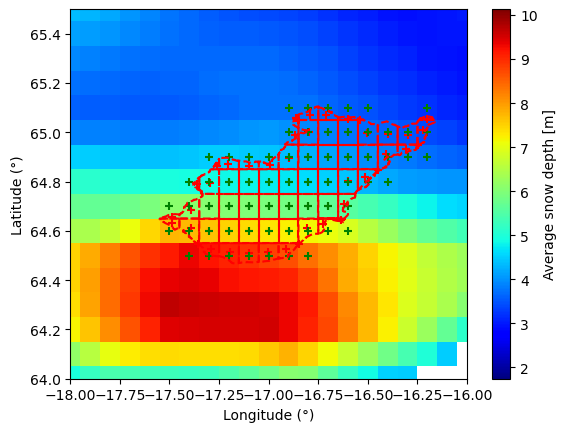

In [13]:
mapV = shp.Reader("D:/MEMOIRE/SIG/djupa/watershed_v289n_intersect.shp")

X, Y = np.meshgrid(LON, LAT)
sfmap = np.where(sde==-32767.,np.nan,sf) #converting into np.nan values
plt.figure()
plt.pcolormesh(X,Y,sfmap[24]*1000, cmap = 'jet')
plt.colorbar(label='Average snow depth [m]')

for shape in mapV.shapeRecords(): #djupa watershed
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, c='r',linestyle ='--')

for i in range(len(surfdata.y_cent)):
    idxLat = find_nearest(LAT, surfdata.y_cent[i])
    idxLong = find_nearest(LON, surfdata.x_cent[i])
    #print(LAT[idxLat],LON[idxLong])
    
    plt.scatter(surfdata.x_cent[i],surfdata.y_cent[i], marker='+', c='r')
    plt.scatter(LON[idxLong], LAT[idxLat], marker='+', c='green')
    
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.xlim(-18,-16)
plt.ylim(64.0,65.5)
plt.show()

### Computing the precipitation, ETR and snow melt with a surface ratio

In [14]:
dicth = {}
fid = list(surfdata.fid)

D = [.74,.78,1.02,1.15,1.33,1.36,1.37,1.25,1.09,.92,.72,.70]

for idp in range(len(fid)) :
    lat = surfdata.y_cent[idp]
    lon = surfdata.x_cent[idp]
    idxLat = find_nearest(LAT, lat)
    idxLong = find_nearest(LON, lon)
    dsurf = surfdata.surface[idp]/totsurf
    #print(dsurf)
    P = []
    T = []
    SM = []
    SF = []
    IceSM = []
    #Mr = []
    for t in range(len(time)) :
        if t != len(time)-1 :
            dt = datime[t+1]-datime[t]
            dt = dt.days
        else :
            dt = 31
            
        tc = float(temp[t][idxLat][idxLong])-273.15
        tsde = float(sde[t][idxLat][idxLong])
        
        P.append(float(prcp[t][idxLat][idxLong])*dsurf*dt*1000)
        T.append(tc)
        SM.append(float(smlt[t][idxLat][idxLong])*dsurf*dt*1000)
        SF.append(float(sf[t][idxLat][idxLong])*dsurf*dt*1000)
        
        
        #calculating the snow melting on ice
        if binIce[idp] == True:
            IceSM.append(float(smlt[t][idxLat][idxLong])*dsurf*dt*1000)
        else :
            IceSM.append(0)
        #calculating the melting ice
        #if tc >= 0 and binIce[idp] == True and tsde <= 1:
        #    Mr.append((1.56+5.338*tc)*dsurf*dt)
        #else :
        #    Mr.append(0)
    
    LP = np.array(P)-np.array(SF)
    #L = 0.05*np.array(T)**3 + 25*np.array(T) + 300
    #W = LP + np.array(SM)
    #ETR = np.array(W)/(0.9+np.array(W)**2/L**2)**1/2
    ETP = np.array([])
    for i in range(4) :
        n = 0+12*i
        n1 = 12+12*i
        I = 0
        for t in T[n:n1] :
            if t > 0 :
                I += (t/5)**(3/2)
        #print(I)
        A = (1.6*I/100)+.5
        etp = np.array(D)*16*(10*np.array(T[n:n1])/I)**A
        ETP = np.append(ETP, etp)
    ETP = np.nan_to_num(ETP,nan=0)*dsurf
    #print(len(P),len(T),len(SM),len(ETR),len(SF))
    R = np.block([T,P,list(ETP),list(LP),SF,SM,IceSM])
    dicth.update({str(fid[idp]):R})
    #print(nantest)

C:\Users\julie\AppData\Local\Temp\ipykernel_10112\217106065.py:60: RuntimeWarning: invalid value encountered in power
  etp = np.array(D)*16*(10*np.array(T[n:n1])/I)**A


### Sum each grid the precipitation & Co.

In [15]:
tP = []
tETP = []
tLP = []
tSM = []
tTEMP = []
tIceSM = []

for a in dicth :
    tTEMP.append(dicth[a][0])
    tP.append(dicth[a][1])
    tETP.append(dicth[a][2])
    tLP.append(dicth[a][3])
    tSM.append(dicth[a][5])
    tIceSM.append(dicth[a][6])
sumP = np.sum(np.array(tP), axis = 0)
sumLP = np.sum(np.array(tLP), axis = 0)
sumETP = np.sum(np.array(tETP), axis = 0)
sumSM = np.sum(np.array(tSM), axis = 0)
meanTP = np.mean(np.array(tTEMP), axis = 0)
sumIceSM = np.sum(np.array(tIceSM), axis = 0)

totIN = sumLP + sumSM#+ sumSM  #total of water input

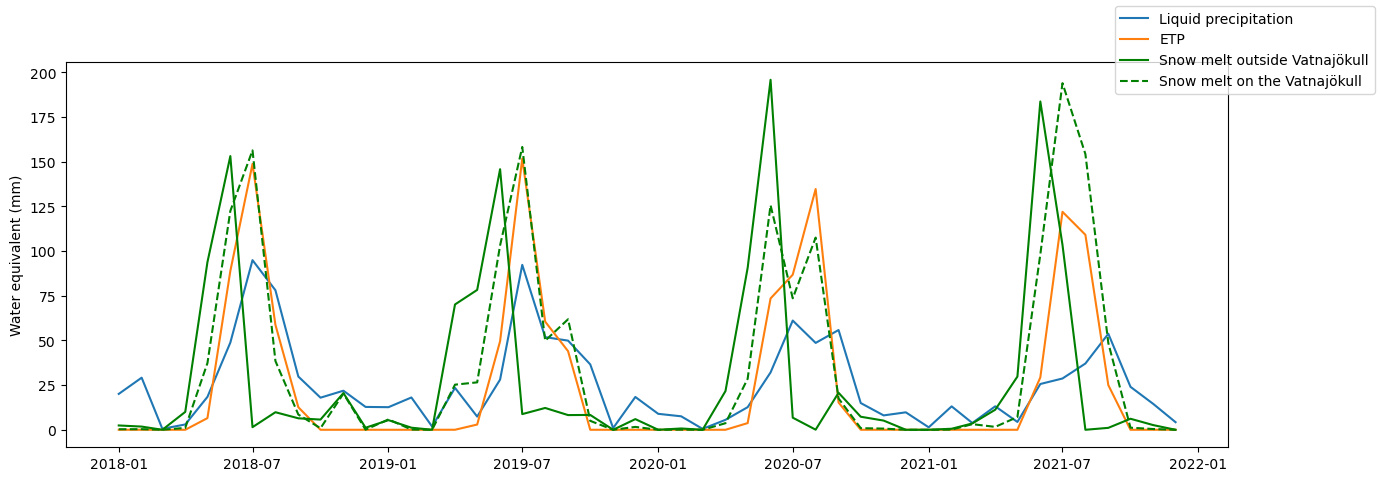

In [16]:
fig, ax1 = plt.subplots(figsize=(15,5)) 

ax1.plot(datime,sumLP, label='Liquid precipitation')
ax1.plot(datime,sumETP, label='ETP')
ax1.plot(datime,sumSM - sumIceSM, label='Snow melt outside Vatnajökull', c='g')
ax1.plot(datime,sumIceSM, label='Snow melt on the Vatnajökull', c='g', linestyle='--')
ax1.set_ylabel('Water equivalent (mm)')

#ax2 = ax1.twinx() 
#ax2.plot(datime,meanTP, label='Mean temperature', c='r', linestyle='--')
#ax2.set_ylabel('Temperature (°C)')
fig.legend()

## Analysis the water discharge

In [71]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [177]:
def reg_inter(X,Y) :
    Xm = np.arange(0, len(X))
    reg = sk.LinearRegression().fit(Xm.reshape(-1, 1), Y.reshape(-1, 1))
    Ypred =  reg.predict(Xm.reshape(-1, 1))
    c = reg.coef_
    return Ypred, c

In [17]:
dhydro = pd.read_csv('D:/MEMOIRE/HYDRO/ALL-DVV/vdv_2018-2022-20230322092719-able-panda.csv',delimiter =';',low_memory=False) 

In [18]:
dich = {}

for a in dhydro :
    if a != 'Time' :
        pQ = np.array(dhydro[a])
        nantest = np.array(pd.notna(pQ))
        Q = np.extract(nantest,pQ).astype(str)
        Q = np.char.replace(Q,',','.').astype(object)
        T = np.extract(nantest,dhydro['Time']).astype(object)
        R = np.block([[T], [Q]])
        dich.update({a: R})
    #print(nantest)

0.04994758895161805 -194.7895607489543
0.029967115975168636 -541.964083004007
0.030963911024986492 -402.1733310796593


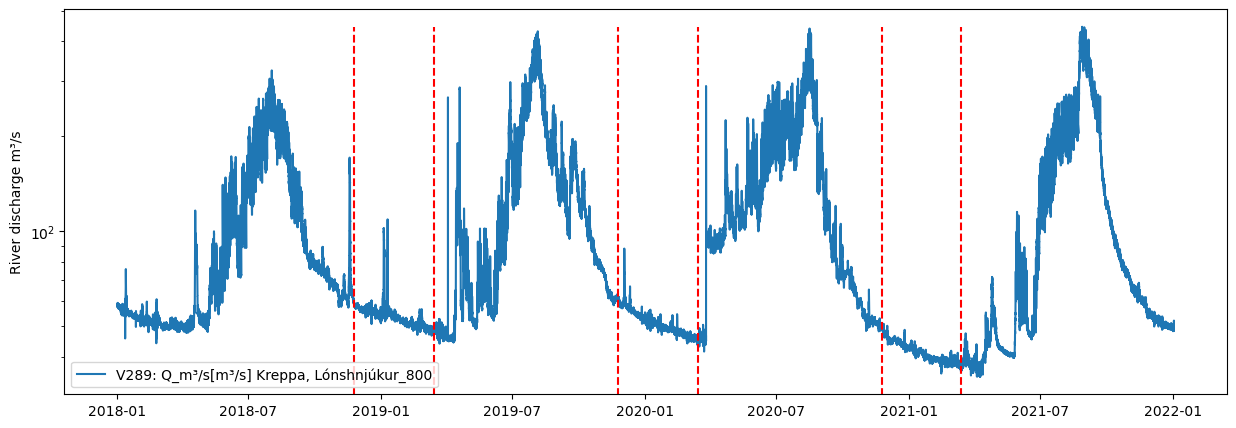

In [229]:
plt.figure(figsize=(15,5))
line = 1
ALPHA = []
StWint = datetime.datetime(year=2017, month=11, day=25)
endWint = datetime.datetime(year=2018, month=3, day=15)
for a in dich :
    if len(dich[a][0]) > 10 and line == 3:
        X = dich[a][0].astype('datetime64[s]')
        Y = dich[a][1].astype('float64')
        #Xmeas = np.datetime64(dich[a][0], "s")
        maxidisch = np.nanmax(Y)
        plt.plot(X,Y, label=a)
        #plt.semilogy(dich[a][0].astype(np.datetime64),dich[a][1].astype('float64'), label=a)
        for i in range(3) :
            StWint += datetime.timedelta(days=365)
            endWint += datetime.timedelta(days=365)
            dT = endWint - StWint
            idxST  = find_nearest(X, np.array(StWint).astype(np.datetime64))
            idxEND = find_nearest(X, np.array(endWint).astype(np.datetime64))
            T = dT.days
            alpha = -1/(T*np.log(Y[idxEND]/Y[idxST]))
            dR = (Y[idxEND]-Y[idxST])/alpha
            ALPHA.append(alpha)
            print(alpha, dR)
            
            #Ypred = reg_inter(X[idxST:idxEND],Y[idxST:idxEND])
            
            plt.plot([StWint, StWint], [0, maxidisch], c='r', linestyle='--')
            plt.plot([endWint, endWint], [0, maxidisch], c='r', linestyle='--')
            #plt.plot(X[idxST:idxEND], Ypred)
        #plt.plot(datime,totIN, label='Liquid precipitation + Snow melt')
        #plt.ylim(0,500)
        plt.yscale('log')
        plt.plot()
    line += 1
plt.ylabel('River discharge m³/s')
plt.legend()
plt.show()

### Sum the discharge on the watershed area

In [21]:
disT = dich['V289: Q_m³/s[m³/s] Kreppa, Lónshnjúkur_800'][0]
disQ = dich['V289: Q_m³/s[m³/s] Kreppa, Lónshnjúkur_800'][1]

In [22]:
sQ = 0
t0 = datetime.datetime.strptime(disT[0], '%Y-%m-%d %H:%M:%S')
sumQ = []
for it in enumerate(disT) :
    tn = datetime.datetime.strptime(disT[it[0]], '%Y-%m-%d %H:%M:%S')
    if it[0] < len(disT) - 1 :
        t1 = datetime.datetime.strptime(disT[it[0]+1], '%Y-%m-%d %H:%M:%S') 
        dt = t1 - tn
    sQ += float(disQ[it[0]])*dt.seconds
    if tn.day == 1 and tn.hour == 0 and tn.minute == 0 and it[0]!=0 :
        #print(tn)
        sumQ.append(sQ)
        sQ = 0

In [23]:
sumQmm = np.array(sumQ)*1000/totsurf

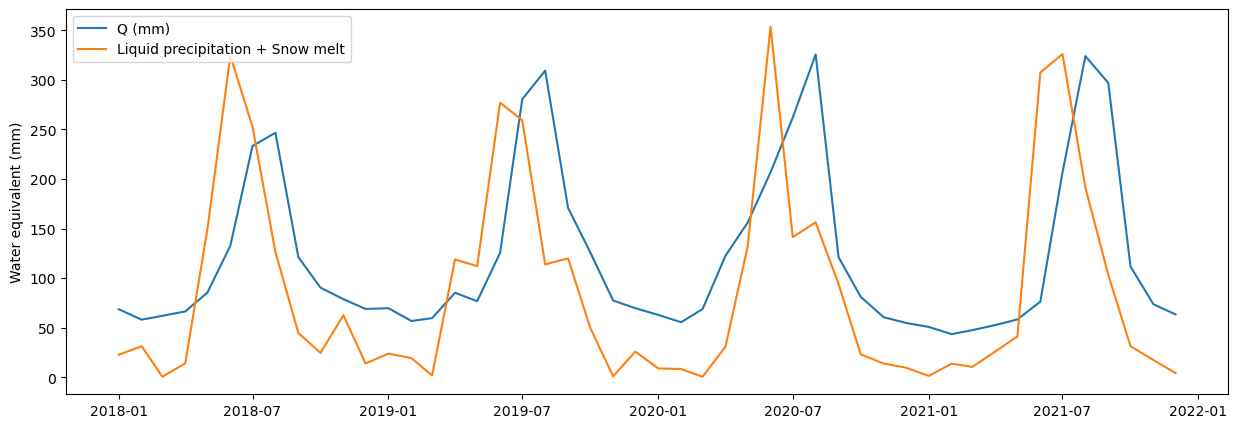

In [24]:
plt.figure(figsize=(15,5))
plt.plot(datime,sumQmm, label='Q (mm)')
plt.plot(datime,totIN, label='Liquid precipitation + Snow melt')
plt.ylabel('Water equivalent (mm)')
plt.legend()

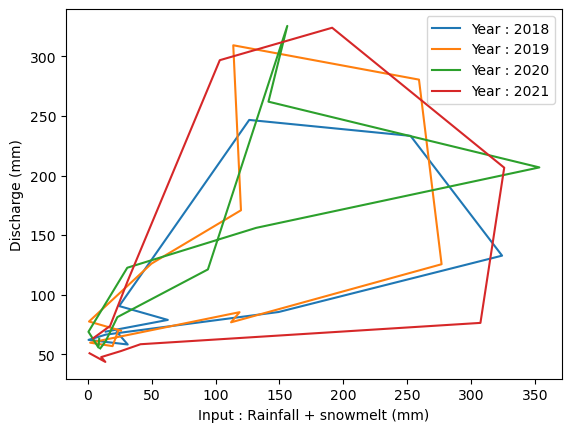

In [25]:
## Thanks Olivier
for i in range (0,4):
    n0 = 0 + 12*i
    n1 = 12 + 12*i
    plt.plot(totIN[n0:n1],sumQmm[n0:n1], label='Year : %i' %(2018+i))
plt.legend()
plt.ylabel('Discharge (mm)')
plt.xlabel('Input : Rainfall + snowmelt (mm)')
plt.show()

### Adding time lag based on Golubev (1973) equation

In [26]:
surfKM = np.where(np.isnan(surfdata["vatna-int"]),0,surfdata["vatna-int"])/10000
tho = 3.8*np.log(np.sum(surfKM)+1) # Golubev (1973)
print('Time lag determine by Golubev (1973) %.1f days' %tho)

Time lag determine by Golubev (1973) 44.9 days


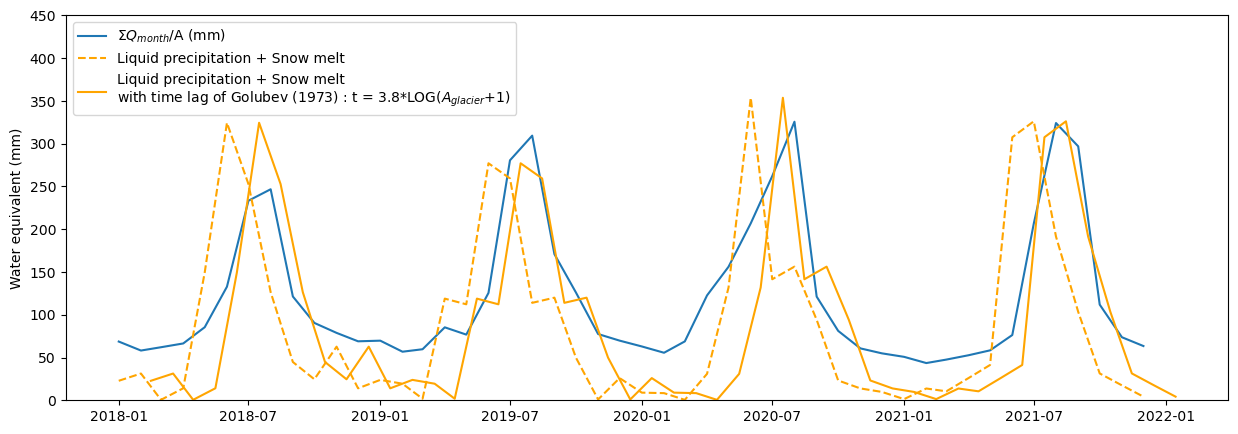

In [27]:
plt.figure(figsize=(15,5))
plt.plot(datime,sumQmm, label='$\Sigma Q_{month}$/A (mm)')
plt.plot(np.array(datime),totIN, label='Liquid precipitation + Snow melt',c='orange', linestyle='--')
plt.plot(np.array(datime)+datetime.timedelta(days=tho),totIN, c='orange', label='Liquid precipitation + Snow melt\nwith time lag of Golubev (1973) : t = 3.8*LOG($A_{glacier}$+1)')
plt.ylim(0,450)
plt.ylabel('Water equivalent (mm)')
plt.legend()

### Water balance
### P + SM = Q + ETR + dR => dR = P + SM - Q - ETR

In [28]:
dR = totIN -sumQmm -ETP #+ 30#terme de fermeture

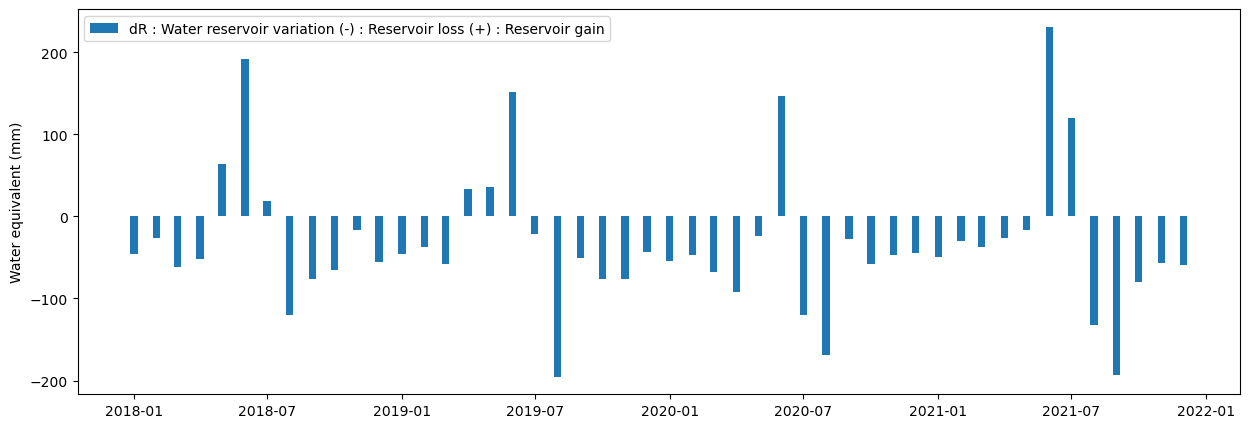

In [29]:
plt.figure(figsize=(15,5))
plt.bar(datime,dR, label='dR : Water reservoir variation (-) : Reservoir loss (+) : Reservoir gain', width=10)
plt.ylabel('Water equivalent (mm)')
plt.legend()

In [30]:
vR = []
R = 0
for elem in dR :
    R+=elem
    vR.append(R)

## Comparing dv/v and dR

In [31]:
def dttReader(folder, search) :
    dvvTime = []
    dvvM = []
    for file in folder :
        find = root+file
        df = pd.read_csv(find)
        if search in list(df['Pairs']) :
            idx = list(df['Pairs']).index(search)
            dvvTime.append(datetime.datetime.strptime(df['Date'][idx],'%Y-%m-%d'))
            dvvM.append(df['M'][idx]*100)
    return dvvTime, dvvM

In [32]:
component = 'ZZ'
mwlength = '030'
filterID = '02'

# Root of the dtt files to plot
root = 'D:/MEMOIRE/MsNoise/ablation/DTT/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
folder = os.listdir(root)
# Root of the stations pairs names
rootpair = 'D:/MEMOIRE/MSNoise/ablation/MWCS/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
pair_name = os.listdir(rootpair)

In [33]:
df = pd.read_csv(root+folder[0])

In [34]:
df

,Date,Pairs,M,EM,A,EA,M0,EM0
0,2018-01-01,VI_BJK_VI_DJK,0.001665,0.001753,0.025267,0.019365,0.003663,0.000911
1,2018-01-01,VI_BJK_VI_GRF,0.000067,0.001406,-0.033346,0.016035,-0.002058,0.001204
2,2018-01-01,VI_BJK_VI_URH,-0.001969,0.000967,0.007123,0.019827,-0.001975,0.000855
3,2018-01-01,VI_DJK_VI_GRF,0.002849,inf,0.008134,inf,0.002546,0.000363
4,2018-01-01,VI_DJK_VI_URH,-0.001092,0.002263,-0.034087,0.042338,0.000039,0.001666
5,2018-01-01,ALL,0.002319,0.000900,0.011211,0.019511,0.002819,0.000220


-0.009557150969298983
-0.02758591727764456
-0.0275710537083459


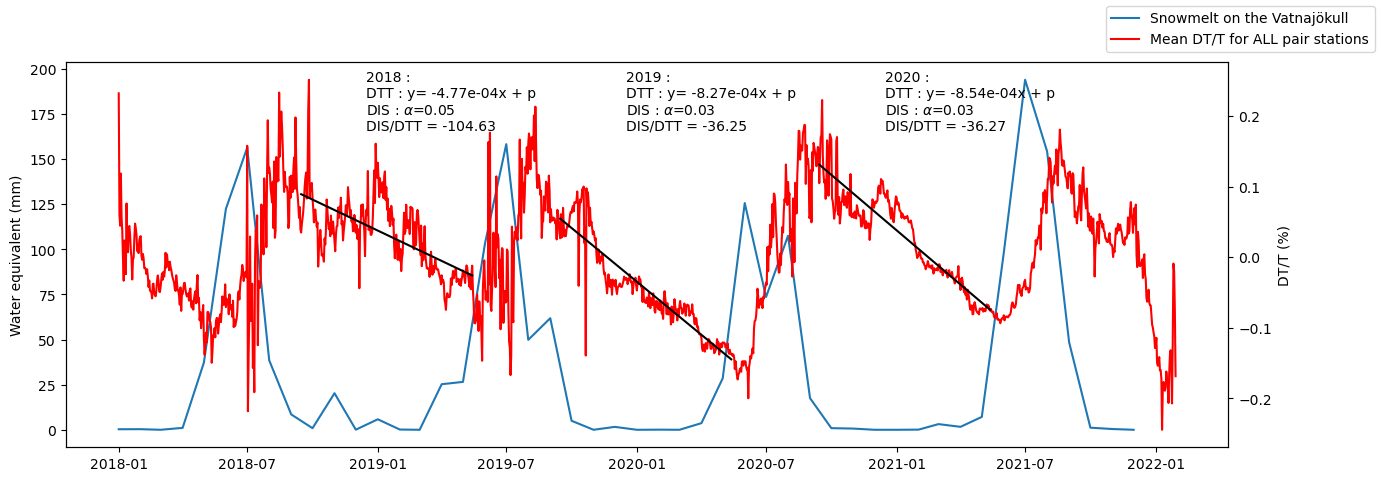

In [228]:
fig, ax1 = plt.subplots(figsize=(15,5)) 
  
ax1.set_ylabel('Water equivalent (mm)')
#ax1.bar(datime,dR, label='dR : Water reservoir variation | (-) : Reservoir loss | (+) : Reservoir gain', width=10)
#ax1.plot(datime,vR, label='dR : Water reservoir variation')  
ax1.plot(datime,sumIceSM, label='Snowmelt on the Vatnajökull')
# Adding Twin Axes

ax2 = ax1.twinx() 
search = 'ALL'
dvvTime, dvvM = dttReader(folder, search)
ax2.set_ylabel('DT/T (%)') 
ax2.plot(dvvTime, dvvM, label='Mean DT/T for %s pair stations' %(search), c='r')

StWint = datetime.datetime(year=2017, month=9, day=15)
endWint = datetime.datetime(year=2018, month=5, day=15)
DTTCOEF = []
for i in range(3) :
    StWint += datetime.timedelta(days=365)
    endWint += datetime.timedelta(days=365)
            
    idxST  = find_nearest(np.array(dvvTime).astype(np.datetime64), np.array(StWint).astype(np.datetime64))
    idxEND = find_nearest(np.array(dvvTime).astype(np.datetime64), np.array(endWint).astype(np.datetime64))

    dvvMpred, coef = reg_inter(np.array(dvvTime[idxST:idxEND]),np.array(dvvM[idxST:idxEND]))
    ax2.plot(dvvTime[idxST:idxEND], dvvMpred, c='k')
    r = ALPHA[i]/coef[0][0]
    strDTT = '%i :\n' %(2018 + i) + f'DTT : y= {coef[0][0]:.2e}x + p\nDIS : $\\alpha$={ALPHA[i]:.2f}\nDIS/DTT = {r:.2f}'
    ax2.text(endWint-datetime.timedelta(days=150),.18, strDTT)
    DTTCOEF.append(coef[0][0])
    print(coef[0][0]/ALPHA[i])
#axset_ylim(-1,1)
# Show plot

fig.legend()
plt.show()

### Ice velocity

In [36]:
RdPts = pd.read_csv('./ice-velocity/RdmPts_A.csv')

In [37]:
foldervelos = os.listdir('./ice-velocity/')

In [42]:
Vmed = []
Vmean = []
Vstd = []
Vt = []

for year in range(2018,2022) :
    for month in range(13) :
        m = '0%i' %month
        if month >= 10 :
            m = str(month)
        for file in foldervelos :
            if file.startswith('iceland_iv_100m_s1_s%i%s01'%(year,m)) :
                print(file)
                dsVelos = nc.Dataset('./ice-velocity/%s'%file)
                ViLON = list(dsVelos['x'][:])
                ViLAT = list(dsVelos['y'][:])
                tV = []
                for i in range(len(RdPts.Y)) :
                    idxViLat = find_nearest(ViLAT, RdPts.Y[i])
                    idxViLon = find_nearest(ViLON, RdPts.X[i])
                    tV.append(dsVelos['land_ice_surface_velocity_magnitude'][idxViLat][idxViLon])
                #print(tV)
                Vmed.append(np.nanmedian(tV))
                Vmean.append(np.nanmean(tV))
                Vstd.append(np.nanstd(tV))
                Vt.append(datetime.datetime(year=year,month=month,day=1))

iceland_iv_100m_s1_s20180101_e20180131_v1.0.nc
iceland_iv_100m_s1_s20180201_e20180228_v1.0.nc
iceland_iv_100m_s1_s20180301_e20180331_v1.0.nc
iceland_iv_100m_s1_s20180401_e20180430_v1.0.nc
iceland_iv_100m_s1_s20180501_e20180531_v1.0.nc
iceland_iv_100m_s1_s20180601_e20180630_v1.0.nc
iceland_iv_100m_s1_s20180701_e20180731_v1.0.nc
iceland_iv_100m_s1_s20180801_e20180831_v1.0.nc
iceland_iv_100m_s1_s20180901_e20180930_v1.0.nc
iceland_iv_100m_s1_s20181001_e20181031_v1.0.nc
iceland_iv_100m_s1_s20181101_e20181130_v1.0.nc
iceland_iv_100m_s1_s20181201_e20181231_v1.0.nc
iceland_iv_100m_s1_s20190101_e20190131_v1.0.nc
iceland_iv_100m_s1_s20190201_e20190228_v1.0.nc
iceland_iv_100m_s1_s20190301_e20190331_v1.0.nc
iceland_iv_100m_s1_s20190401_e20190430_v1.0.nc
iceland_iv_100m_s1_s20190501_e20190531_v1.0.nc
iceland_iv_100m_s1_s20190601_e20190630_v1.0.nc
iceland_iv_100m_s1_s20190701_e20190731_v1.0.nc
iceland_iv_100m_s1_s20190801_e20190831_v1.0.nc
iceland_iv_100m_s1_s20190901_e20190930_v1.0.nc
iceland_iv_10

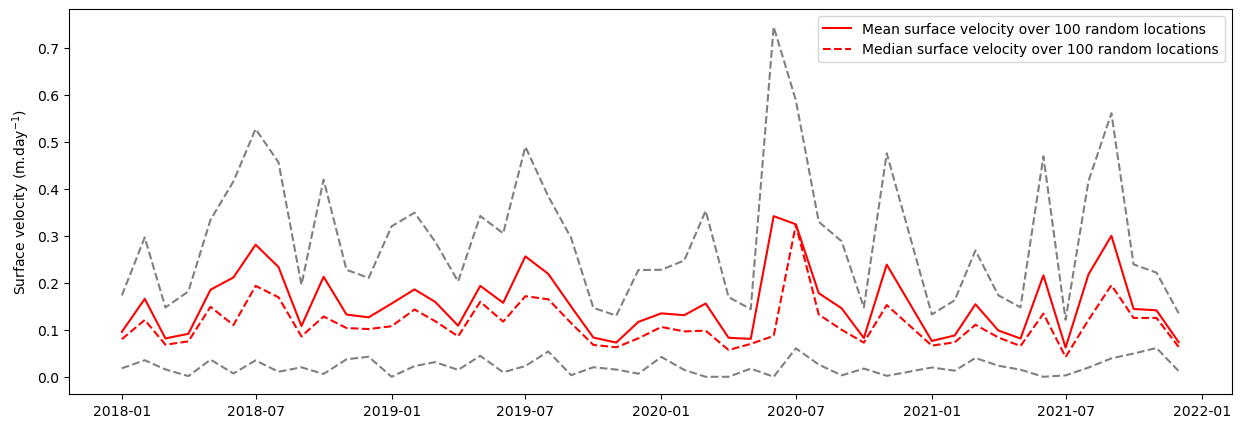

In [51]:
plt.figure(figsize=(15,5))
plt.plot(Vt,Vmean, c='r', label='Mean surface velocity over 100 random locations')
StdMin = np.array(Vmean)-np.array(Vstd)
StdMin = np.where(StdMin < 0, 0, StdMin)
plt.plot(Vt,np.array(Vmean)+np.array(Vstd), c='grey', linestyle='--')
plt.plot(Vt,StdMin, c='grey', linestyle='--')
plt.plot(Vt,Vmed, c='r', linestyle='--', label='Median surface velocity over 100 random locations')
plt.ylabel('Surface velocity (m.day$^{-1}$)')
plt.legend()

### Compare dvv on two frequency bands

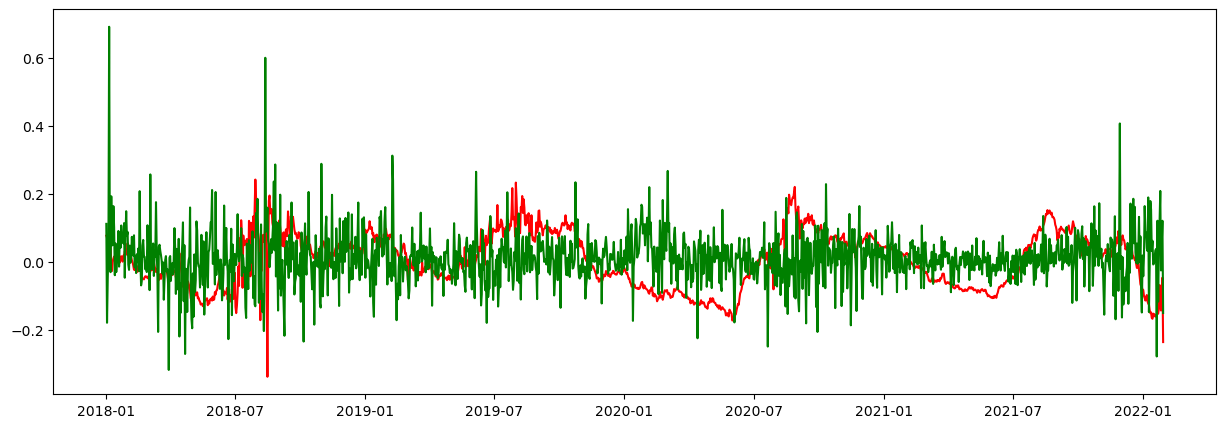

In [48]:
plt.figure(figsize=(15,5))

component = 'ZZ'
mwlength = '030'
filterID1 = '07'
filterID2 = '09'

root = 'D:/MEMOIRE/MsNoise/ablation/DTT/%s/%s_DAYS/%s/' %(filterID1, mwlength, component)
folder1 = os.listdir(root)
dttT1, dttM1 = dttReader(folder1, 'ALL')
plt.plot(dttT1, dttM1, c='r')

root = 'D:/MEMOIRE/MsNoise/ablation/DTT/%s/%s_DAYS/%s/' %(filterID2, mwlength, component)
folder2 = os.listdir(root)
dttT2, dttM2 = dttReader(folder2, 'ALL')
plt.plot(dttT2, dttM2, c='g')

plt.show()